In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout
from keras.utils import to_categorical,plot_model
from keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
import os
import cv2
import math
from imblearn.over_sampling import RandomOverSampler

In [2]:
directory='./Belgium_Datasets'
train_dir=directory+'/BelgiumTSC_Training/Training'
test_dir=directory+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [3]:
print(trainclasses)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061']


In [4]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0,116.0,118.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0,99.0,103.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0,87.0,89.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0,78.0,86.0
5,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0.0,0,106.0,115.0


In [5]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0,4591.000000,4591.000000
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0,103.220649,90.534524
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0,61.111287,50.557826
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0,11.000000,9.000000
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0,64.000000,57.000000
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0,88.000000,80.000000
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0,124.000000,111.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0,604.000000,440.000000


In [6]:
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = ""
Epochs=200
train_length = len(df)
Y_col_name="ClassId"

In [7]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  4591


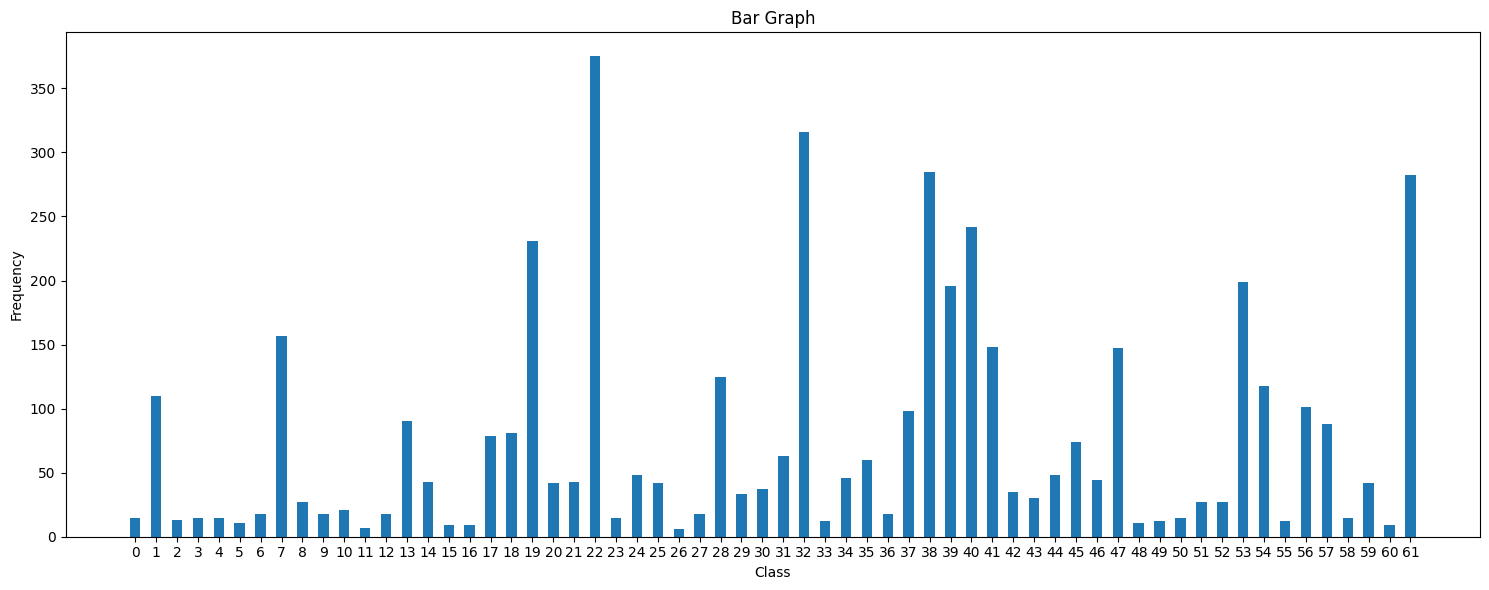

In [8]:
#Statistics of Data
viewStatistics(df)

In [9]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  4591


Total Training Examples :  23250


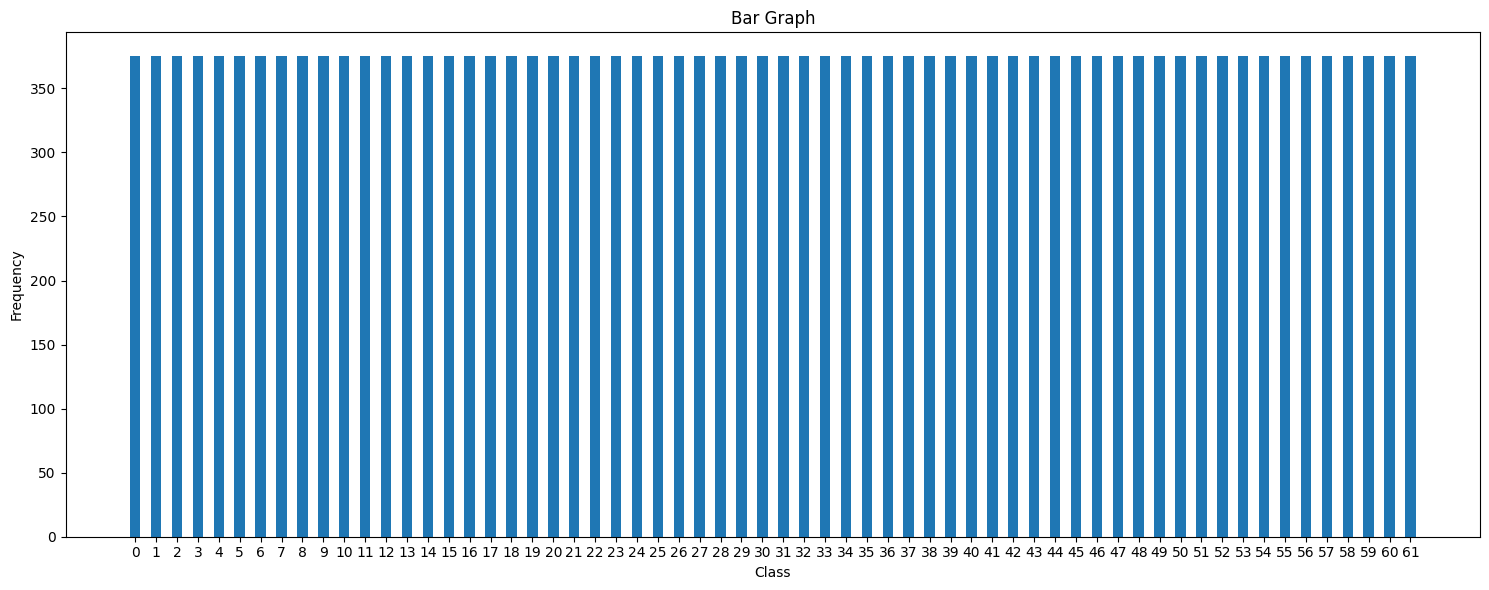

In [10]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled
df[Y_col_name].astype(str)

viewStatistics(df)

In [11]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0,116.0,118.0,0.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0,99.0,103.0,0.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0,87.0,89.0,0.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0,78.0,86.0,0.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0,106.0,115.0,0.0


In [12]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title(directory+val[0])
        print(directory+val[0])
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+str(val[7]))
    ax.axis('off')
    

./Belgium_Datasets/BelgiumTSC_Training/Training/00052/00901_00002.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00007/01653_00002.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00019/00967_00002.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00003/00391_00000.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00048/00128_00000.ppm


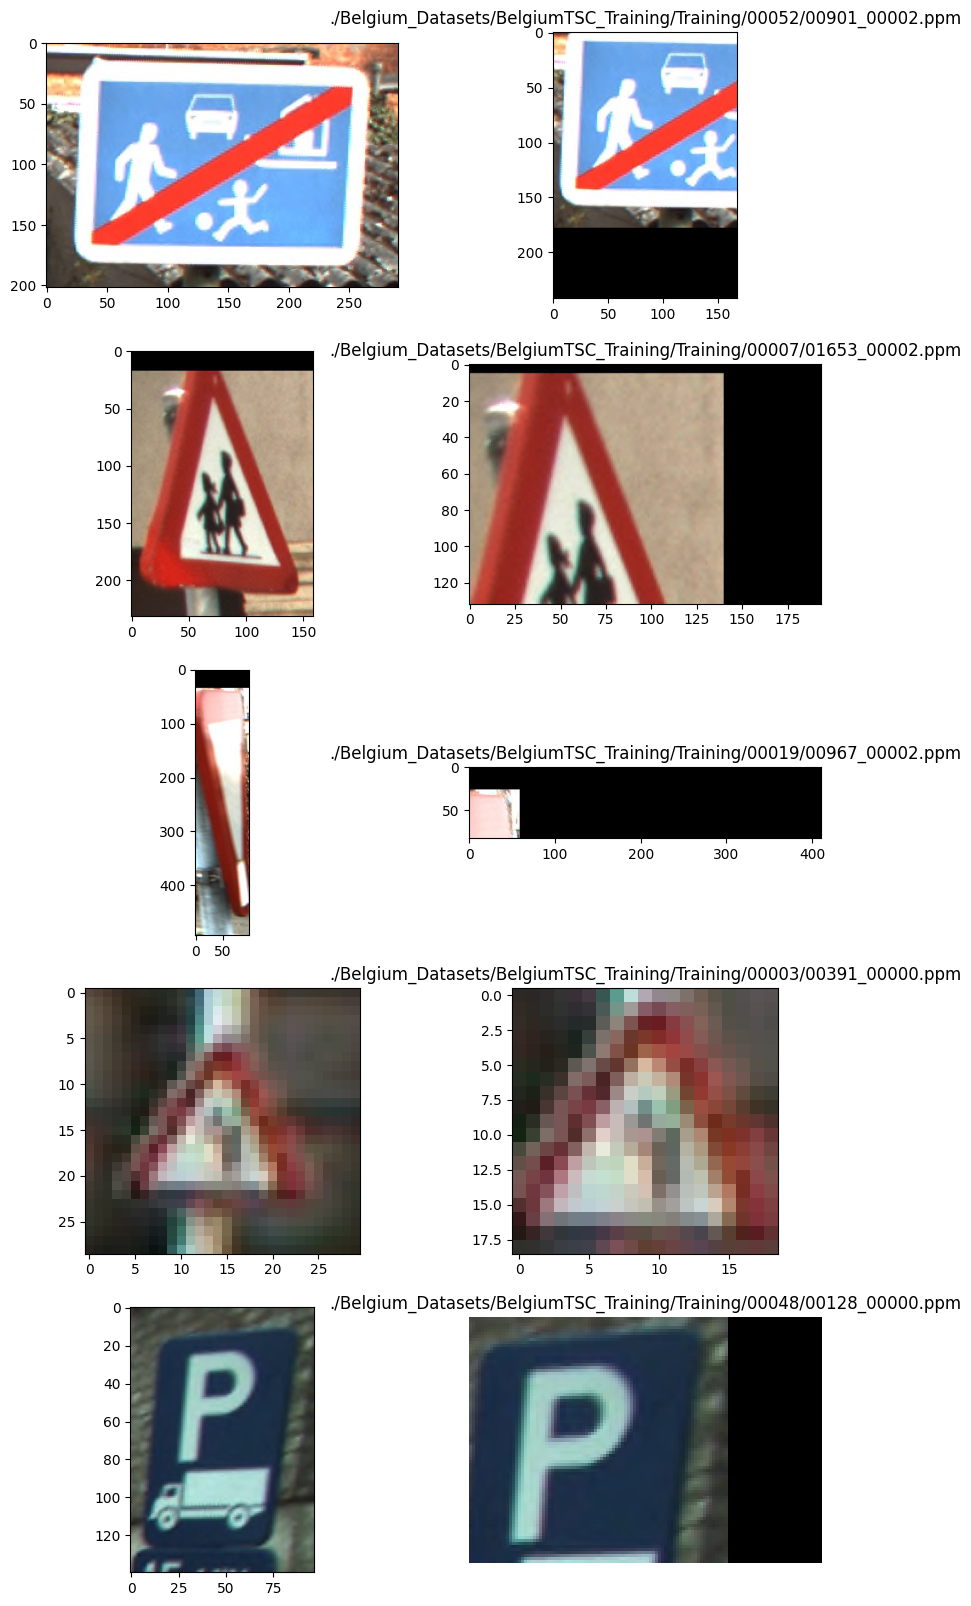

In [13]:
showExamples(df)

In [14]:
# Load pre-trained ResNet50 model with random weights
model = MobileNetV3Large(weights=None, input_shape=(resize_x, resize_y, 3), classes=num_of_classes)

# Display the model summary
model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 16, 16, 16)           432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 16, 16, 16)           64        ['Conv[0][0]']                
 lization)                                                                         

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
print(df["ClassId"].dtype)
# df["ClassId"] = df["ClassId"].astype(str)
# print(df["ClassId"].dtype)

float64


In [17]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0,116.0,118.0,0.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0,99.0,103.0,0.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0,87.0,89.0,0.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0,78.0,86.0,0.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0,106.0,115.0,0.0


In [18]:
class Data:
    def __init__(self,df,size_x,size_y):
        self.df = df
        self.root = directory
        self.resize_x = size_x
        self.resize_y = size_y

    def resize_and_center(self,image, target_height, target_width):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

    def Do_Crop(self,path,x1,y1,x2,y2):
        img = Image.open(self.root+path)
        img = img.crop((x1,y1,x2,y2))
        img = img.resize((resize_x,resize_y))
        img = np.array(img,dtype=float)
        img = img/255.0
        return img
    
    def Row_Data(self,row):
        img = self.Do_Crop(row["Filename"],row["Roi.X1"],row["Roi.Y1"],row["Roi.X2"],row["Roi.Y2"])
        self.X.append(img)
        self.Y.append(int(row["ClassId"]))
        
    def Get_Data(self):
        self.X = []
        self.Y = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            self.Row_Data(row)
        self.X = np.array(self.X)
        self.Y = np.array(self.Y,dtype=int)


In [19]:
def miniDataTrain(model,df,train_split):
    data = Data(df,resize_x,resize_y)
    data.Get_Data()
    X_train = data.X
    Y_train = []
    for val in data.Y:
        x = [0]*num_of_classes
        x[int(val)]=1
        x = np.array(x)
        Y_train.append(x)
    Y_train = np.array(Y_train)
    Y_train
#     for i,v in enumerate(X_train):
#         print(data.Y[i])
#         plt.imshow(v)
#         plt.show()
    history = model.fit(X_train,Y_train,epochs=1,batch_size=len(X_train),validation_split=1-train_split,verbose=0)
    training_accuracy = history.history['accuracy'][0]
    validation_accuracy = history.history['val_accuracy'][0]
    loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    return [training_accuracy,validation_accuracy,loss,val_loss]

def SingleEpochTrain(model,df,batchsize=256,train_split=0.8):
    num_train = len(df)
    df = df.sample(frac=1)
    num_mini_trains = math.ceil(num_train/batchsize)
    training_accuracy = 0
    validation_accuracy = 0
    loss = 0
    val_loss = 0
    starting_time = time.time()
    for i in range(num_mini_trains):      
        if(num_mini_trains == i+1):
            presentBatchSize = num_train - i*batchsize
        else :
            presentBatchSize = batchsize      
        df1 = df.iloc[i*batchsize:i*batchsize+presentBatchSize,:]
        params = miniDataTrain(model,df1,train_split)
        training_accuracy += presentBatchSize*params[0]
        validation_accuracy+= presentBatchSize*params[1]
        loss += params[2]
        val_loss += params[3]
    training_accuracy/=(num_train)
    validation_accuracy/=(num_train)
    ending_time = time.time()
    total_time = ending_time - starting_time
    total_time/=60
    print("Accuracy: ",training_accuracy," Val Accuracy: ",validation_accuracy," Trained for ",total_time," min")
    return [training_accuracy,validation_accuracy,loss,val_loss];

In [ ]:
start_time   = time.time()

training_accuracy = []
validation_accuracy = []
loss = []
val_loss = []

for i in range(Epochs):
    print("Epoch : ", i)
    params = SingleEpochTrain(model,df)
    training_accuracy.append(params[0])
    validation_accuracy.append(params[1])
    loss.append(params[2])
    val_loss.append(params[3])

end_time = time.time()
print("Time taken : ", (end_time - start_time)/60," min")

Epoch :  0
Accuracy:  0.5604410706591862  Val Accuracy:  0.016092639041203324  Trained for  2.4071022669474282  min
Epoch :  1
Accuracy:  0.8481199651841195  Val Accuracy:  0.015669148537420456  Trained for  2.10596346060435  min
Epoch :  2


In [ ]:
#Saving the model
model.save(filename)

In [ ]:

epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self,dataframe, x1_col, y1_col, x2_col, y2_col, Path,directory, preprocessing_function=None, **kwargs):
        super().__init__(preprocessing_function=preprocessing_function, **kwargs)
        self.dataframe=dataframe
        self.directory = directory
        self.x1_col = x1_col
        self.y1_col = y1_col
        self.x2_col = x2_col
        self.y2_col = y2_col
        self.Path   = Path
        

    def flow_from_dataframe(self, *args, **kwargs):
        generator = super().flow_from_dataframe(*args, **kwargs)
        generator.Path = self.Path
        return generator

    def __getitem__(self, index):
        # Override the __getitem__ method to load and preprocess images based on coordinates
        current_batch = super().__getitem__(index)
        
        # Load original images and preprocess based on coordinates
        for i in range(len(current_batch[0])):
            x1 = self.dataframe[self.x1_col].iloc[index * self.batch_size + i]
            y1 = self.dataframe[self.y1_col].iloc[index * self.batch_size + i]
            x2 = self.dataframe[self.x2_col].iloc[index * self.batch_size + i]
            y2 = self.dataframe[self.y2_col].iloc[index * self.batch_size + i]
            original_image_path = self.dataframe[self.Path].iloc[index * self.batch_size + i]
            original_image = Image.open(directory+original_image_path)
            region = original_image.crop((x1, y1, x2, y2))
            region_array = np.array(region)
            
            # Apply preprocessing_function if specified
            if self.preprocessing_function:
                region_array = self.preprocessing_function(region_array)

            current_batch[0][i] = region_array

        return current_batch

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df.head()

In [ ]:
# #Saving the model
# model.save("MobileNetV3-Belgium")

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,training_accuracy,color="blue",label="Training Accuracy")
plt.plot(epochs,validation_accuracy,color="red",label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
epochs  = [x for x in range(Epochs)]
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,color="blue",label="training loss")
plt.plot(epochs,val_loss,color="red",label="validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

 ***Test Image Classification and Accuracy Calculation***

In [ ]:
# #Loading weights into CNN model 
# model = tf.keras.models.load_model("CNN_Model_SimpleLayered_Belgium")

In [ ]:
df_test=[[]]
df_test=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df=pd.concat([df_test,df1],ignore_index=True)
print("Number of Test Images are ", len(df_test))
df_test['Rotate']=0
df_test=df_test.dropna()
df_test.head()

In [ ]:
viewStatistics(df_test)
print("Total Training Examples : ",len(df_test))

In [ ]:
# showExamples(df_test)
df_test.describe()

In [ ]:
showTestExamples(df_test)

In [ ]:

X = df_test.drop(Y_col_name, axis=1)
y = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_test = pd.DataFrame(X_resampled, columns=X.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [ ]:
df_test.head()

In [ ]:
test_images = []
data = Data(df_test,resize_x,resize_y)
data.Get_Data()
X_test  = data.X
y_test = data.Y

In [ ]:
test_images = []
data = Data(df_test,resize_x,resize_y)
data.Get_Data()
X_test  = data.X
y_test = data.Y

In [ ]:
y_test = test_generator.classes
pred = model.predict(test_generator)
y_pred = np.argmax(pred, axis=1)

In [ ]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("\n\n\n Summarizing the results : ")
report

In [ ]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Belgium Datasets Confusion Matrix using CNN Simple Layered')
plt.show()